In [ ]:
"""
🛡️ TikTok Safety Platform - Exploratory Data Analysis (EDA)
============================================================
📚 Course: SE363 - Big Data Platform Application Development
🏛️ Institution: University of Information Technology (UIT) - VNU-HCM

Mục tiêu EDA:
1. Phân tích Text Data (captions, comments) - Harmful vs Not Harmful
2. Phân tích Video Data (metadata, duration, resolution)
3. So sánh 3 nguồn dữ liệu: data/, data_1/, data_viet/
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import glob
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
import warnings

# Tắt cảnh báo
warnings.filterwarnings("ignore")

# Cấu hình hiển thị
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

print("✅ Đã import thư viện thành công!")
print("=" * 60)
print("🛡️ TikTok Safety Platform - EDA Notebook")
print("=" * 60)


✅ Đã import thư viện thành công!
🛡️ TikTok Safety Platform - EDA Notebook


In [ ]:
# =============================================================================
# 📍 CẤU HÌNH ĐƯỜNG DẪN CHO 3 NGUỒN DỮ LIỆU
# =============================================================================

# Base path - thư mục gốc của project
BASE_PATH = os.path.dirname(os.getcwd())  # Parent của notebooks/
if "notebooks" in os.getcwd():
    BASE_PATH = os.path.dirname(os.getcwd())
else:
    BASE_PATH = os.getcwd()

print(f"📍 Base Path: {BASE_PATH}")

# -----------------------------------------------------------------------------
# 1. TEXT DATA PATHS
# -----------------------------------------------------------------------------
TEXT_PATHS = {
    "combined": os.path.join(
        BASE_PATH, "processed_data/text/TRAINING_TEXT_DATA_FINAL_COMBINED.csv"
    ),
    "train": os.path.join(BASE_PATH, "processed_data/text/train_split.csv"),
    "val": os.path.join(BASE_PATH, "processed_data/text/eval_split.csv"),
    "test": os.path.join(BASE_PATH, "processed_data/text/test_split.csv"),
}

# -----------------------------------------------------------------------------
# 2. VIDEO DATA PATHS - 3 nguồn chính
# -----------------------------------------------------------------------------
VIDEO_SOURCES = {
    "data": {
        "harmful": os.path.join(BASE_PATH, "data/videos/harmful"),
        "not_harmful": os.path.join(BASE_PATH, "data/videos/not_harmful"),
        "crawl_csv": os.path.join(BASE_PATH, "data/crawl/tiktok_links.csv"),
    },
    "data_1": {
        "harmful": os.path.join(BASE_PATH, "data_1/videos/harmful"),
        "not_harmful": os.path.join(BASE_PATH, "data_1/videos/not_harmful"),
        "crawl_csv": os.path.join(BASE_PATH, "data_1/crawl/sub_tiktok_links_1.csv"),
    },
    "data_viet": {
        "harmful": os.path.join(BASE_PATH, "data_viet/videos/harmful"),
        "not_harmful": os.path.join(BASE_PATH, "data_viet/videos/not_harmful"),
        "crawl_csv": os.path.join(BASE_PATH, "data_viet/crawl/tiktok_links_viet.csv"),
    },
}

# -----------------------------------------------------------------------------
# 3. KIỂM TRA ĐƯỜNG DẪN
# -----------------------------------------------------------------------------
print("\n" + "=" * 60)
print("📋 KIỂM TRA ĐƯỜNG DẪN DỮ LIỆU")
print("=" * 60)

# Check Text paths
print("\n📝 TEXT DATA:")
for name, path in TEXT_PATHS.items():
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"   {exists} {name}: {os.path.basename(path)}")

# Check Video paths
print("\n🎬 VIDEO DATA:")
for source_name, paths in VIDEO_SOURCES.items():
    print(f"\n   📁 {source_name.upper()}:")
    for label, path in paths.items():
        if label == "crawl_csv":
            exists = "✅" if os.path.exists(path) else "❌"
            print(f"      {exists} crawl_csv: {os.path.basename(path)}")
        else:
            if os.path.exists(path):
                # Đếm số video folders
                folders = [
                    f
                    for f in os.listdir(path)
                    if os.path.isdir(os.path.join(path, f)) and f.startswith("video_")
                ]
                print(f"      ✅ {label}: {len(folders)} video folders")
            else:
                print(f"      ❌ {label}: NOT FOUND")


📍 Base Path: /home/guest/Projects/SE363/UIT-SE363-Big-Data-Platform-Application-Development

📋 KIỂM TRA ĐƯỜNG DẪN DỮ LIỆU

📝 TEXT DATA:
   ✅ combined: TRAINING_TEXT_DATA_FINAL_COMBINED.csv
   ✅ train: train_split.csv
   ✅ val: eval_split.csv
   ✅ test: test_split.csv

🎬 VIDEO DATA:

   📁 DATA:
      ✅ harmful: 450 video folders
      ✅ not_harmful: 552 video folders
      ✅ crawl_csv: tiktok_links.csv

   📁 DATA_1:
      ✅ harmful: 650 video folders
      ✅ not_harmful: 350 video folders
      ✅ crawl_csv: sub_tiktok_links_1.csv

   📁 DATA_VIET:
      ✅ harmful: 650 video folders
      ✅ not_harmful: 350 video folders
      ✅ crawl_csv: tiktok_links_viet.csv


# 📊 PHẦN 1: EDA TEXT DATA
## 1.1 Load và tổng quan dữ liệu Text

Text data chứa **captions** và **comments** từ TikTok videos, được xử lý với format:
- `video_id`: ID của video TikTok
- `text`: Nội dung text (caption + comments, ngăn cách bởi `[SEP]`)
- `label`: 0 = Not Harmful, 1 = Harmful
- `confidence`: Độ tin cậy của nhãn

In [ ]:
# =============================================================================
# 📝 LOAD TEXT DATA
# =============================================================================


def load_text_data():
    """Load tất cả text data splits và combined dataset"""
    dataframes = {}

    for name, path in TEXT_PATHS.items():
        if os.path.exists(path):
            df = pd.read_csv(path)
            # Clean data
            df = df.dropna(subset=["text", "label"])
            df["label"] = df["label"].astype(int)
            df["text"] = df["text"].astype(str)
            dataframes[name] = df
            print(f"✅ Loaded {name}: {len(df):,} samples")
        else:
            print(f"❌ Missing: {path}")

    return dataframes


# Load data
text_dfs = load_text_data()

# Sử dụng combined dataset cho phân tích chính
if "combined" in text_dfs:
    df_text = text_dfs["combined"]
    print(f"\n📊 Tổng số mẫu (Combined): {len(df_text):,}")
    print("\n🔍 Xem trước dữ liệu:")
    display(df_text.head(3))


✅ Loaded combined: 2,430 samples
✅ Loaded train: 1,456 samples
✅ Loaded val: 182 samples
✅ Loaded test: 182 samples

📊 Tổng số mẫu (Combined): 2,430

🔍 Xem trước dữ liệu:


,video_id,path,filename,text,label,confidence
0,6719103916010687750,harmful/video_495/6719103916010687750.mp4,6719103916010687750.mp4,mr_bean.s_car [SEP] それなw [SEP] 確かこの後ビーンが弓を持って風...,0,0.15
1,6760705827876752645,harmful/video_868/6760705827876752645.mp4,6760705827876752645.mp4,believe i'm a clown and i don't see how this c...,0,0.23
2,6848484851381751041,not_harmful/video_315/6848484851381751041.mp4,6848484851381751041.mp4,cho xin video đi bn ơi [SEP] gút chóp em [SEP]...,1,0.67


## 1.2 Phân tích Phân bố Nhãn (Class Distribution)

Kiểm tra mức độ mất cân bằng giữa 2 class:
- **Label 0**: Not Harmful (Nội dung an toàn)
- **Label 1**: Harmful (Nội dung có hại - bạo lực, ma túy, tự hại, ...)

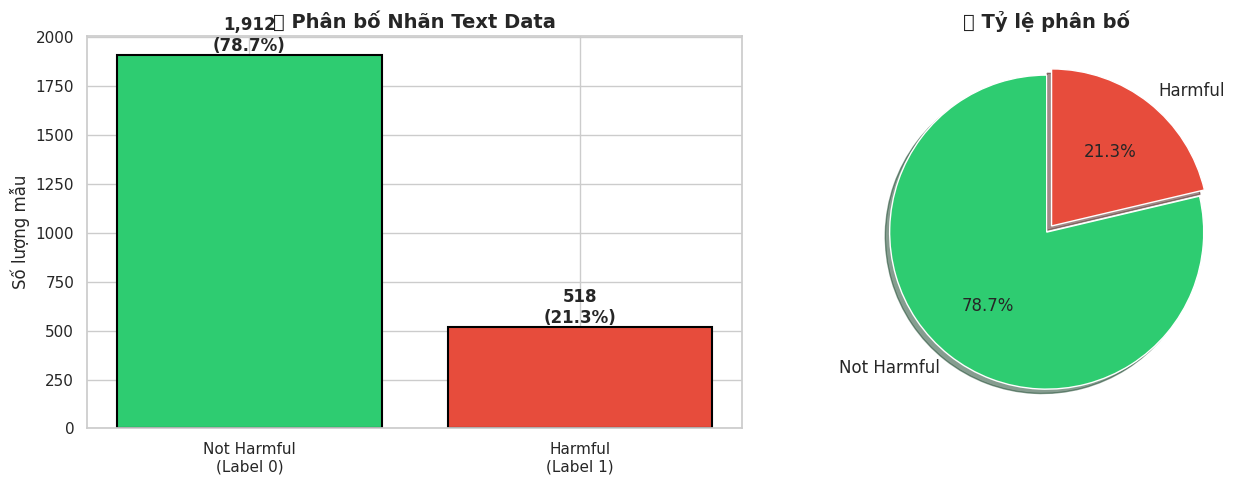

🔬 BÁO CÁO PHÂN BỐ NHÃN TEXT DATA
📊 Tổng số mẫu: 2,430
   ├─ Label 0 (Not Harmful): 1,912 (78.68%)
   └─ Label 1 (Harmful):     518 (21.32%)
------------------------------------------------------------
⚠️  Imbalance Ratio: 1 : 3.69
⚖️  Class Weights (sklearn 'balanced'):
   ├─ Weight[0]: 0.6355
   └─ Weight[1]: 2.3456
------------------------------------------------------------
💡 Gợi ý config cho training:
   "class_weights": [0.6355, 2.3456]


In [ ]:
# =============================================================================
# 📊 PHÂN BỐ NHÃN VÀ CLASS WEIGHTS
# =============================================================================
from sklearn.utils.class_weight import compute_class_weight

if "df_text" in dir():
    # Thống kê
    label_counts = df_text["label"].value_counts().sort_index()
    total = len(df_text)
    count_0 = label_counts.get(0, 0)
    count_1 = label_counts.get(1, 0)

    # Vẽ biểu đồ
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart
    colors = ["#2ecc71", "#e74c3c"]  # Green for safe, Red for harmful
    ax1 = axes[0]
    bars = ax1.bar(
        ["Not Harmful\n(Label 0)", "Harmful\n(Label 1)"],
        [count_0, count_1],
        color=colors,
        edgecolor="black",
        linewidth=1.5,
    )
    ax1.set_title("📊 Phân bố Nhãn Text Data", fontsize=14, fontweight="bold")
    ax1.set_ylabel("Số lượng mẫu")

    # Annotation
    for bar, count in zip(bars, [count_0, count_1]):
        pct = 100 * count / total
        ax1.annotate(
            f"{count:,}\n({pct:.1f}%)",
            xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )

    # Pie chart
    ax2 = axes[1]
    ax2.pie(
        [count_0, count_1],
        labels=["Not Harmful", "Harmful"],
        colors=colors,
        autopct="%1.1f%%",
        startangle=90,
        explode=(0, 0.05),
        shadow=True,
        textprops={"fontsize": 12},
    )
    ax2.set_title("📈 Tỷ lệ phân bố", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Tính Class Weights
    classes = np.unique(df_text["label"])
    weights = compute_class_weight("balanced", classes=classes, y=df_text["label"])

    # Report
    print("=" * 60)
    print("🔬 BÁO CÁO PHÂN BỐ NHÃN TEXT DATA")
    print("=" * 60)
    print(f"📊 Tổng số mẫu: {total:,}")
    print(f"   ├─ Label 0 (Not Harmful): {count_0:,} ({100*count_0/total:.2f}%)")
    print(f"   └─ Label 1 (Harmful):     {count_1:,} ({100*count_1/total:.2f}%)")
    print("-" * 60)
    ratio = count_0 / count_1 if count_1 > 0 else float("inf")
    print(f"⚠️  Imbalance Ratio: 1 : {ratio:.2f}")
    print(f"⚖️  Class Weights (sklearn 'balanced'):")
    print(f"   ├─ Weight[0]: {weights[0]:.4f}")
    print(f"   └─ Weight[1]: {weights[1]:.4f}")
    print("-" * 60)
    print("💡 Gợi ý config cho training:")
    print(f'   "class_weights": [{weights[0]:.4f}, {weights[1]:.4f}]')
    print("=" * 60)


## 1.3 Phân tích Độ dài Text (Text Length Analysis)

Phân tích số từ trong mỗi sample để xác định `max_seq_length` phù hợp cho model BERT/CafeBERT.

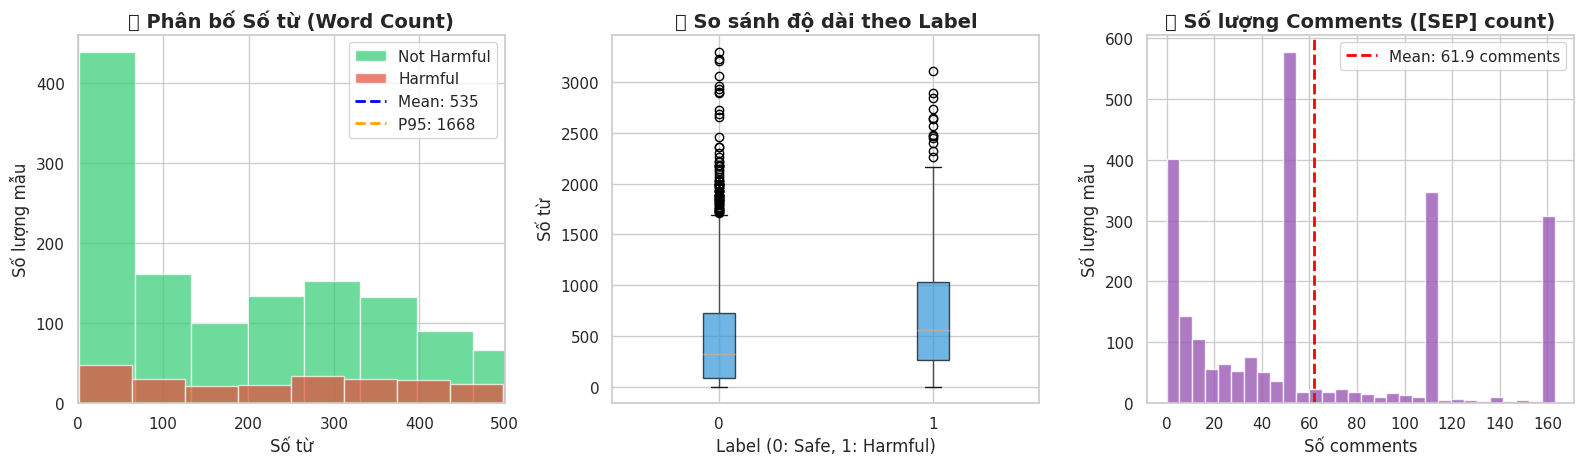

📏 THỐNG KÊ ĐỘ DÀI TEXT
📊 Tổng quan:
   ├─ Trung bình: 535.4 từ
   ├─ Median:     357.0 từ
   ├─ Min:        1 từ
   ├─ Max:        3302 từ
   ├─ P95:        1668 từ (bao phủ 95% data)
   └─ P99:        2347 từ (bao phủ 99% data)
------------------------------------------------------------
📊 So sánh theo Label:
   Label 0 (Not Harmful):
      ├─ Mean: 485.6 từ
      └─ Median: 319.0 từ
   Label 1 (Harmful):
      ├─ Mean: 719.0 từ
      └─ Median: 555.0 từ
------------------------------------------------------------
💡 GỢI Ý max_seq_length cho BERT/CafeBERT:
   ├─ Tối thiểu: 256 tokens (bao phủ median)
   ├─ Khuyến nghị: 512 tokens (bao phủ P95)
   └─ Tối đa: 1024 tokens (nếu RAM cho phép)


In [ ]:
# =============================================================================
# 📏 PHÂN TÍCH ĐỘ DÀI TEXT
# =============================================================================

if "df_text" in dir():
    # Tính số từ và số ký tự
    df_text["word_count"] = df_text["text"].apply(lambda x: len(str(x).split()))
    df_text["char_count"] = df_text["text"].apply(lambda x: len(str(x)))
    df_text["sep_count"] = df_text["text"].apply(lambda x: str(x).count("[SEP]"))

    # Thống kê theo label
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # 1. Word count distribution
    ax1 = axes[0]
    for label, color, name in [
        (0, "#2ecc71", "Not Harmful"),
        (1, "#e74c3c", "Harmful"),
    ]:
        subset = df_text[df_text["label"] == label]["word_count"]
        ax1.hist(subset, bins=50, alpha=0.7, color=color, label=name, edgecolor="white")
    ax1.axvline(
        df_text["word_count"].mean(),
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f'Mean: {df_text["word_count"].mean():.0f}',
    )
    ax1.axvline(
        np.percentile(df_text["word_count"], 95),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f'P95: {np.percentile(df_text["word_count"], 95):.0f}',
    )
    ax1.set_title("📊 Phân bố Số từ (Word Count)", fontweight="bold")
    ax1.set_xlabel("Số từ")
    ax1.set_ylabel("Số lượng mẫu")
    ax1.legend()
    ax1.set_xlim(0, 500)

    # 2. Box plot by label
    ax2 = axes[1]
    df_text.boxplot(
        column="word_count",
        by="label",
        ax=ax2,
        patch_artist=True,
        boxprops=dict(facecolor="#3498db", alpha=0.7),
    )
    ax2.set_title("📦 So sánh độ dài theo Label", fontweight="bold")
    ax2.set_xlabel("Label (0: Safe, 1: Harmful)")
    ax2.set_ylabel("Số từ")
    plt.suptitle("")  # Remove auto title

    # 3. SEP count (số comments)
    ax3 = axes[2]
    df_text["sep_count"].hist(
        bins=30, ax=ax3, color="#9b59b6", edgecolor="white", alpha=0.8
    )
    ax3.axvline(
        df_text["sep_count"].mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f'Mean: {df_text["sep_count"].mean():.1f} comments',
    )
    ax3.set_title("💬 Số lượng Comments ([SEP] count)", fontweight="bold")
    ax3.set_xlabel("Số comments")
    ax3.set_ylabel("Số lượng mẫu")
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # Report thống kê chi tiết
    print("=" * 60)
    print("📏 THỐNG KÊ ĐỘ DÀI TEXT")
    print("=" * 60)

    stats_overall = df_text["word_count"].describe()
    p95 = np.percentile(df_text["word_count"], 95)
    p99 = np.percentile(df_text["word_count"], 99)

    print(f"📊 Tổng quan:")
    print(f"   ├─ Trung bình: {stats_overall['mean']:.1f} từ")
    print(f"   ├─ Median:     {stats_overall['50%']:.1f} từ")
    print(f"   ├─ Min:        {stats_overall['min']:.0f} từ")
    print(f"   ├─ Max:        {stats_overall['max']:.0f} từ")
    print(f"   ├─ P95:        {p95:.0f} từ (bao phủ 95% data)")
    print(f"   └─ P99:        {p99:.0f} từ (bao phủ 99% data)")
    print("-" * 60)

    # So sánh theo label
    print("📊 So sánh theo Label:")
    for label in [0, 1]:
        subset = df_text[df_text["label"] == label]["word_count"]
        name = "Not Harmful" if label == 0 else "Harmful"
        print(f"   Label {label} ({name}):")
        print(f"      ├─ Mean: {subset.mean():.1f} từ")
        print(f"      └─ Median: {subset.median():.1f} từ")

    print("-" * 60)
    print(f"💡 GỢI Ý max_seq_length cho BERT/CafeBERT:")
    print(f"   ├─ Tối thiểu: 256 tokens (bao phủ median)")
    print(f"   ├─ Khuyến nghị: 512 tokens (bao phủ P95)")
    print(f"   └─ Tối đa: 1024 tokens (nếu RAM cho phép)")
    print("=" * 60)


## 1.4 Word Cloud - Từ khóa nổi bật theo nhãn

Visualize các từ khóa phổ biến trong nội dung Harmful vs Not Harmful để hiểu đặc trưng của từng class.

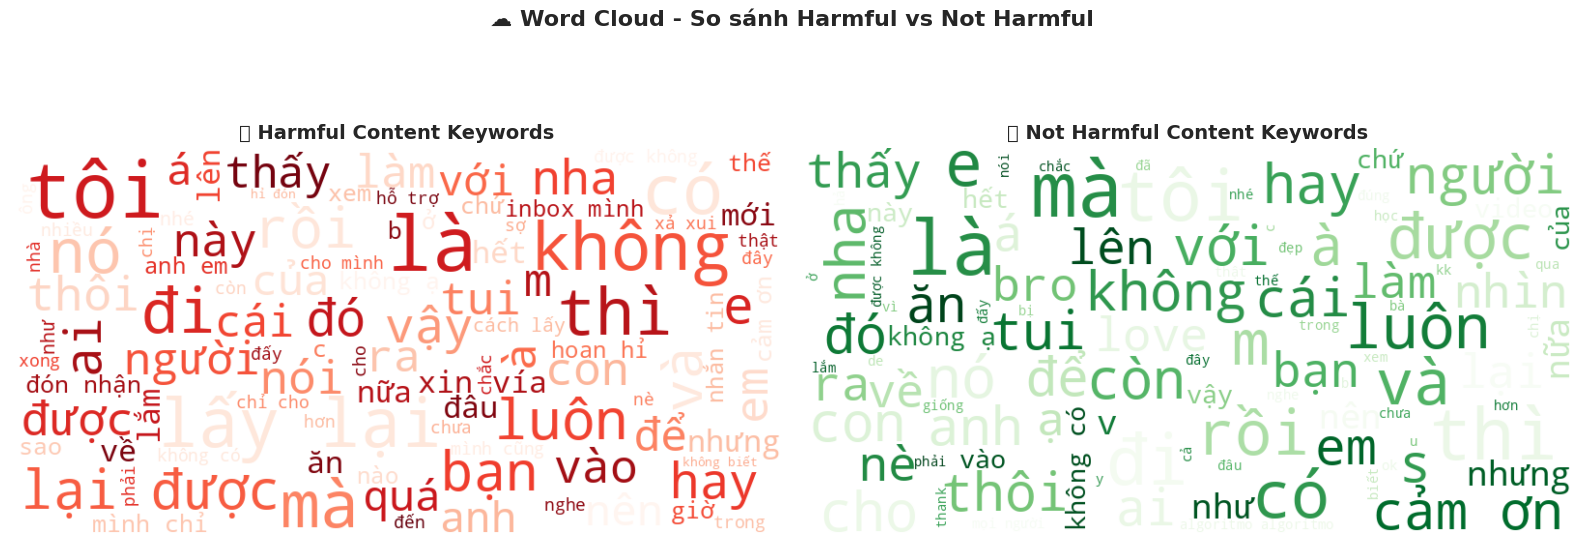

🔤 TOP 10 TỪ PHỔ BIẾN THEO NHÃN

🔴 Harmful:
    1. không: 5,326
    2. mình: 3,515
    3. được: 3,036
    4. cho: 2,646
    5. tôi: 2,507
    6. lại: 2,397
    7. thì: 2,358
    8. người: 1,855
    9. bạn: 1,719
   10. cũng: 1,700

🟢 Not Harmful:
    1. không: 10,284
    2. tôi: 5,964
    3. được: 4,611
    4. mình: 4,544
    5. the: 4,283
    6. thì: 3,956
    7. này: 3,901
    8. bạn: 3,784
    9. quá: 3,676
   10. vậy: 3,607

🟢 Not Harmful:
    1. không: 10,284
    2. tôi: 5,964
    3. được: 4,611
    4. mình: 4,544
    5. the: 4,283
    6. thì: 3,956
    7. này: 3,901
    8. bạn: 3,784
    9. quá: 3,676
   10. vậy: 3,607


In [ ]:
# =============================================================================
# ☁️ WORD CLOUD THEO NHÃN
# =============================================================================


def generate_wordcloud(text_series, title, colormap="viridis", ax=None):
    """Generate word cloud từ text series"""
    # Gộp text và loại bỏ [SEP] marker
    text_combined = " ".join(text_series.astype(str))
    text_combined = text_combined.replace("[SEP]", " ")

    # Tạo word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap=colormap,
        max_words=100,
        min_font_size=10,
        max_font_size=80,
        random_state=42,
    ).generate(text_combined)

    if ax:
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(title, fontsize=14, fontweight="bold")
    return wordcloud


if "df_text" in dir():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Harmful content
    generate_wordcloud(
        df_text[df_text["label"] == 1]["text"],
        "🔴 Harmful Content Keywords",
        colormap="Reds",
        ax=axes[0],
    )

    # Not Harmful content
    generate_wordcloud(
        df_text[df_text["label"] == 0]["text"],
        "🟢 Not Harmful Content Keywords",
        colormap="Greens",
        ax=axes[1],
    )

    plt.suptitle(
        "☁️ Word Cloud - So sánh Harmful vs Not Harmful",
        fontsize=16,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

    # Top từ phổ biến
    print("=" * 60)
    print("🔤 TOP 10 TỪ PHỔ BIẾN THEO NHÃN")
    print("=" * 60)

    for label, name, emoji in [(1, "Harmful", "🔴"), (0, "Not Harmful", "🟢")]:
        texts = " ".join(df_text[df_text["label"] == label]["text"].astype(str))
        texts = texts.replace("[SEP]", " ").lower()
        words = [w for w in texts.split() if len(w) > 2]
        word_freq = Counter(words).most_common(10)

        print(f"\n{emoji} {name}:")
        for i, (word, freq) in enumerate(word_freq, 1):
            print(f"   {i:2}. {word}: {freq:,}")
    print("=" * 60)


## 1.5 Phân tích Ngôn ngữ trong Text (Vietnamese vs English vs Other)

Dữ liệu TikTok chứa đa ngôn ngữ. Phân tích tỷ lệ ngôn ngữ để hiểu đặc điểm dataset.

🔍 Đang phân tích ngôn ngữ...


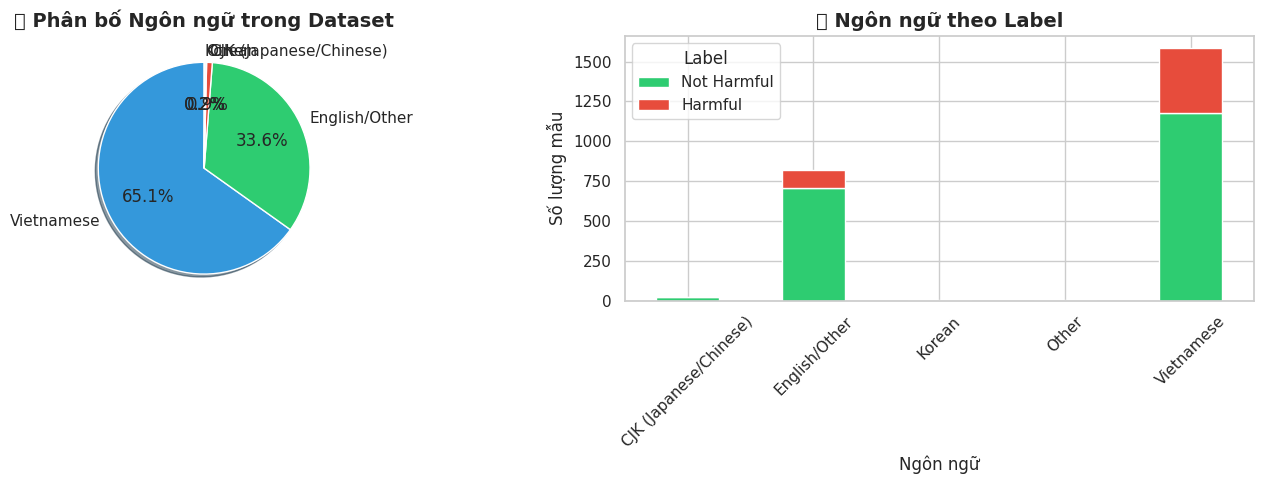

🌐 THỐNG KÊ NGÔN NGỮ
   Vietnamese: 1,583 (65.1%)
   English/Other: 817 (33.6%)
   CJK (Japanese/Chinese): 21 (0.9%)
   Other: 5 (0.2%)
   Korean: 4 (0.2%)


In [ ]:
# =============================================================================
# 🌐 PHÂN TÍCH NGÔN NGỮ (Đơn giản dựa trên ký tự)
# =============================================================================

import re


def detect_language_simple(text):
    """Phát hiện ngôn ngữ đơn giản dựa trên ký tự đặc trưng"""
    text = str(text)

    # Vietnamese characters
    viet_chars = re.findall(
        r"[àáảãạăằắẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđ]",
        text.lower(),
    )
    # Japanese/Chinese characters
    cjk_chars = re.findall(r"[\u4e00-\u9fff\u3040-\u30ff]", text)
    # Korean
    korean_chars = re.findall(r"[\uac00-\ud7af]", text)
    # English (only letters)
    english_chars = re.findall(r"[a-zA-Z]", text)

    total = len(viet_chars) + len(cjk_chars) + len(korean_chars) + len(english_chars)
    if total == 0:
        return "Other"

    viet_ratio = len(viet_chars) / total
    cjk_ratio = len(cjk_chars) / total
    korean_ratio = len(korean_chars) / total

    if viet_ratio > 0.1:
        return "Vietnamese"
    elif cjk_ratio > 0.3:
        return "CJK (Japanese/Chinese)"
    elif korean_ratio > 0.3:
        return "Korean"
    else:
        return "English/Other"


if "df_text" in dir():
    # Detect language
    print("🔍 Đang phân tích ngôn ngữ...")
    df_text["language"] = df_text["text"].apply(detect_language_simple)

    # Thống kê
    lang_counts = df_text["language"].value_counts()

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Pie chart
    colors = ["#3498db", "#2ecc71", "#e74c3c", "#9b59b6"]
    axes[0].pie(
        lang_counts.values,
        labels=lang_counts.index,
        colors=colors[: len(lang_counts)],
        autopct="%1.1f%%",
        startangle=90,
        shadow=True,
    )
    axes[0].set_title("🌐 Phân bố Ngôn ngữ trong Dataset", fontweight="bold")

    # Stacked bar by label
    lang_label_counts = (
        df_text.groupby(["language", "label"]).size().unstack(fill_value=0)
    )
    lang_label_counts.plot(
        kind="bar",
        stacked=True,
        ax=axes[1],
        color=["#2ecc71", "#e74c3c"],
        edgecolor="white",
    )
    axes[1].set_title("📊 Ngôn ngữ theo Label", fontweight="bold")
    axes[1].set_xlabel("Ngôn ngữ")
    axes[1].set_ylabel("Số lượng mẫu")
    axes[1].legend(["Not Harmful", "Harmful"], title="Label")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Report
    print("=" * 60)
    print("🌐 THỐNG KÊ NGÔN NGỮ")
    print("=" * 60)
    for lang, count in lang_counts.items():
        pct = 100 * count / len(df_text)
        print(f"   {lang}: {count:,} ({pct:.1f}%)")
    print("=" * 60)


# 🎬 PHẦN 2: EDA VIDEO DATA
## 2.1 Thống kê Video từ 3 nguồn: data/, data_1/, data_viet/

Phân tích metadata của video TikTok:
- **Số lượng video** theo nguồn và nhãn
- **Duration** (thời lượng)
- **Resolution** (độ phân giải)
- **FPS** (frame rate)

In [ ]:
# =============================================================================
# 🎬 THỐNG KÊ VIDEO TỪ 3 NGUỒN
# =============================================================================


def count_videos_in_folder(folder_path):
    """Đếm số video trong folder (cấu trúc video_xxx/xxx.mp4)"""
    if not os.path.exists(folder_path):
        return 0, []

    video_files = []
    video_exts = (".mp4", ".avi", ".mov", ".mkv", ".webm")

    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path) and item.startswith("video_"):
            # Tìm video file trong subfolder
            for f in os.listdir(item_path):
                if f.lower().endswith(video_exts):
                    video_files.append(os.path.join(item_path, f))
                    break  # Chỉ lấy 1 video mỗi folder

    return len(video_files), video_files


# Thống kê từng nguồn
video_stats = {}
all_video_paths = []

print("=" * 70)
print("🎬 THỐNG KÊ VIDEO THEO NGUỒN DỮ LIỆU")
print("=" * 70)

for source_name, paths in VIDEO_SOURCES.items():
    harmful_count, harmful_videos = count_videos_in_folder(paths["harmful"])
    not_harmful_count, not_harmful_videos = count_videos_in_folder(paths["not_harmful"])

    video_stats[source_name] = {
        "harmful": harmful_count,
        "not_harmful": not_harmful_count,
        "total": harmful_count + not_harmful_count,
        "harmful_paths": harmful_videos,
        "not_harmful_paths": not_harmful_videos,
    }

    all_video_paths.extend([(p, 1, source_name) for p in harmful_videos])
    all_video_paths.extend([(p, 0, source_name) for p in not_harmful_videos])

    print(f"\n📁 {source_name.upper()}:")
    print(f"   ├─ Harmful:     {harmful_count:,} videos")
    print(f"   ├─ Not Harmful: {not_harmful_count:,} videos")
    print(f"   └─ Total:       {harmful_count + not_harmful_count:,} videos")

# Tổng hợp
total_videos = sum(s["total"] for s in video_stats.values())
total_harmful = sum(s["harmful"] for s in video_stats.values())
total_not_harmful = sum(s["not_harmful"] for s in video_stats.values())

print("\n" + "-" * 70)
print(f"📊 TỔNG HỢP TẤT CẢ NGUỒN:")
print(f"   ├─ Total Harmful:     {total_harmful:,}")
print(f"   ├─ Total Not Harmful: {total_not_harmful:,}")
print(f"   └─ GRAND TOTAL:       {total_videos:,} videos")
print("=" * 70)


🎬 THỐNG KÊ VIDEO THEO NGUỒN DỮ LIỆU

📁 DATA:
   ├─ Harmful:     435 videos
   ├─ Not Harmful: 524 videos
   └─ Total:       959 videos

📁 DATA_1:
   ├─ Harmful:     540 videos
   ├─ Not Harmful: 298 videos
   └─ Total:       838 videos

📁 DATA_VIET:
   ├─ Harmful:     540 videos
   ├─ Not Harmful: 278 videos
   └─ Total:       818 videos

----------------------------------------------------------------------
📊 TỔNG HỢP TẤT CẢ NGUỒN:
   ├─ Total Harmful:     1,515
   ├─ Total Not Harmful: 1,100
   └─ GRAND TOTAL:       2,615 videos


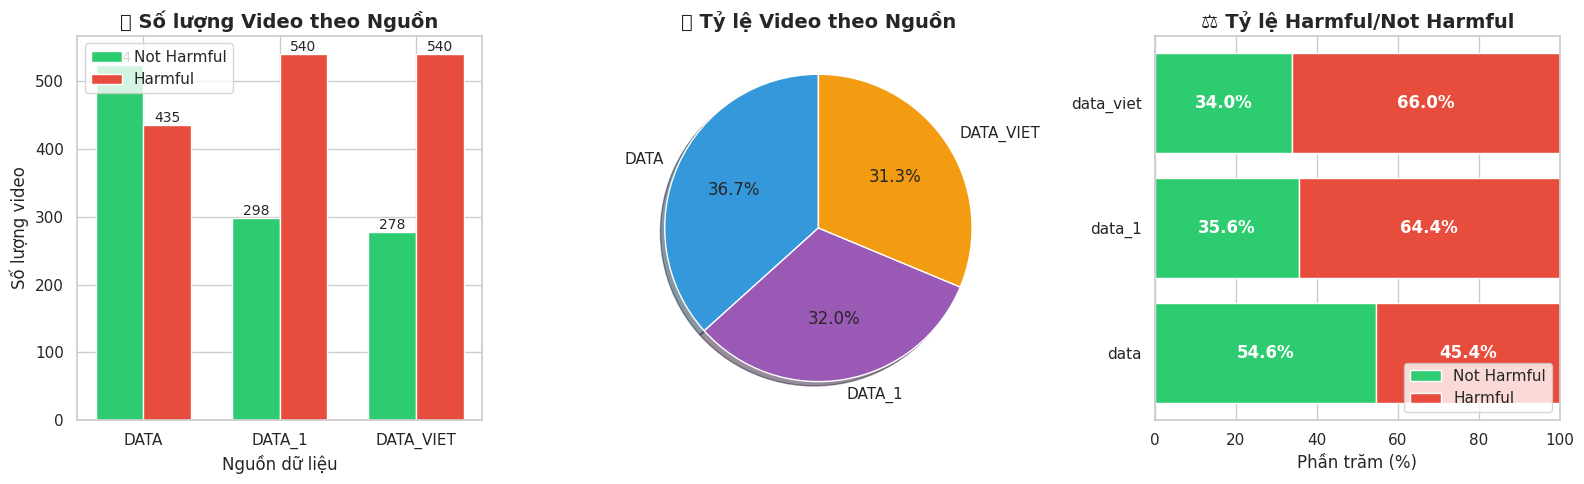

In [ ]:
# =============================================================================
# 📊 VISUALIZE PHÂN BỐ VIDEO THEO NGUỒN VÀ NHÃN
# =============================================================================

if video_stats:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # 1. Bar chart theo nguồn
    ax1 = axes[0]
    sources = list(video_stats.keys())
    harmful_counts = [video_stats[s]["harmful"] for s in sources]
    not_harmful_counts = [video_stats[s]["not_harmful"] for s in sources]

    x = np.arange(len(sources))
    width = 0.35

    bars1 = ax1.bar(
        x - width / 2, not_harmful_counts, width, label="Not Harmful", color="#2ecc71"
    )
    bars2 = ax1.bar(
        x + width / 2, harmful_counts, width, label="Harmful", color="#e74c3c"
    )

    ax1.set_title("📊 Số lượng Video theo Nguồn", fontweight="bold")
    ax1.set_xlabel("Nguồn dữ liệu")
    ax1.set_ylabel("Số lượng video")
    ax1.set_xticks(x)
    ax1.set_xticklabels([s.upper() for s in sources])
    ax1.legend()

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(
                f"{int(height)}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=10,
            )

    # 2. Pie chart tổng hợp
    ax2 = axes[1]
    totals = [video_stats[s]["total"] for s in sources]
    colors = ["#3498db", "#9b59b6", "#f39c12"]
    ax2.pie(
        totals,
        labels=[s.upper() for s in sources],
        colors=colors[: len(sources)],
        autopct="%1.1f%%",
        startangle=90,
        shadow=True,
    )
    ax2.set_title("📈 Tỷ lệ Video theo Nguồn", fontweight="bold")

    # 3. Stacked bar - Harmful ratio
    ax3 = axes[2]
    harmful_pct = [
        (
            100 * video_stats[s]["harmful"] / video_stats[s]["total"]
            if video_stats[s]["total"] > 0
            else 0
        )
        for s in sources
    ]
    not_harmful_pct = [100 - p for p in harmful_pct]

    ax3.barh(sources, not_harmful_pct, color="#2ecc71", label="Not Harmful")
    ax3.barh(
        sources, harmful_pct, left=not_harmful_pct, color="#e74c3c", label="Harmful"
    )
    ax3.set_title("⚖️ Tỷ lệ Harmful/Not Harmful", fontweight="bold")
    ax3.set_xlabel("Phần trăm (%)")
    ax3.legend(loc="lower right")
    ax3.set_xlim(0, 100)

    # Add percentage labels
    for i, (nh, h) in enumerate(zip(not_harmful_pct, harmful_pct)):
        ax3.text(
            nh / 2,
            i,
            f"{nh:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )
        ax3.text(
            nh + h / 2,
            i,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()


## 2.2 Phân tích Metadata Video (Duration, Resolution, FPS)

Quét video samples để phân tích các đặc tính kỹ thuật quan trọng cho model training.

In [ ]:
# =============================================================================
# 🎥 PHÂN TÍCH METADATA VIDEO (SAMPLE)
# =============================================================================


def get_video_metadata(video_path):
    """Lấy metadata của video sử dụng OpenCV"""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0

        cap.release()

        return {
            "width": width,
            "height": height,
            "resolution": f"{width}x{height}",
            "fps": round(fps, 1),
            "duration": round(duration, 2),
            "frame_count": frame_count,
        }
    except Exception as e:
        return None


# Sample videos để phân tích (giới hạn để chạy nhanh)
SAMPLE_PER_SOURCE = 200  # Số video mỗi nguồn

print(f"🎥 Đang quét metadata từ {SAMPLE_PER_SOURCE} videos mỗi nguồn...")
print("   (Có thể mất vài phút...)\n")

video_metadata = []

for source_name, stats in video_stats.items():
    all_paths = stats["harmful_paths"] + stats["not_harmful_paths"]

    # Sample ngẫu nhiên
    if len(all_paths) > SAMPLE_PER_SOURCE:
        sample_paths = np.random.choice(all_paths, SAMPLE_PER_SOURCE, replace=False)
    else:
        sample_paths = all_paths

    for path in tqdm(sample_paths, desc=f"Scanning {source_name}"):
        meta = get_video_metadata(path)
        if meta:
            meta["source"] = source_name
            meta["label"] = 1 if "/harmful/" in path else 0
            video_metadata.append(meta)

# Tạo DataFrame
df_video = pd.DataFrame(video_metadata)
print(f"\n✅ Đã quét thành công {len(df_video)} videos")
display(df_video.head())


🎥 Đang quét metadata từ 200 videos mỗi nguồn...
   (Có thể mất vài phút...)



Scanning data_viet: 100%|██████████| 200/200 [00:00<00:00, 202.06it/s]


✅ Đã quét thành công 600 videos


,width,height,resolution,fps,duration,frame_count,source,label
0,1080,1908,1080x1908,60.0,88.02,5281,data,0
1,720,1280,720x1280,30.0,18.17,545,data,0
2,1080,1920,1080x1920,29.9,42.83,1280,data,1
3,1920,1080,1920x1080,30.0,28.73,862,data,0
4,1080,1920,1080x1920,30.0,76.57,2297,data,0


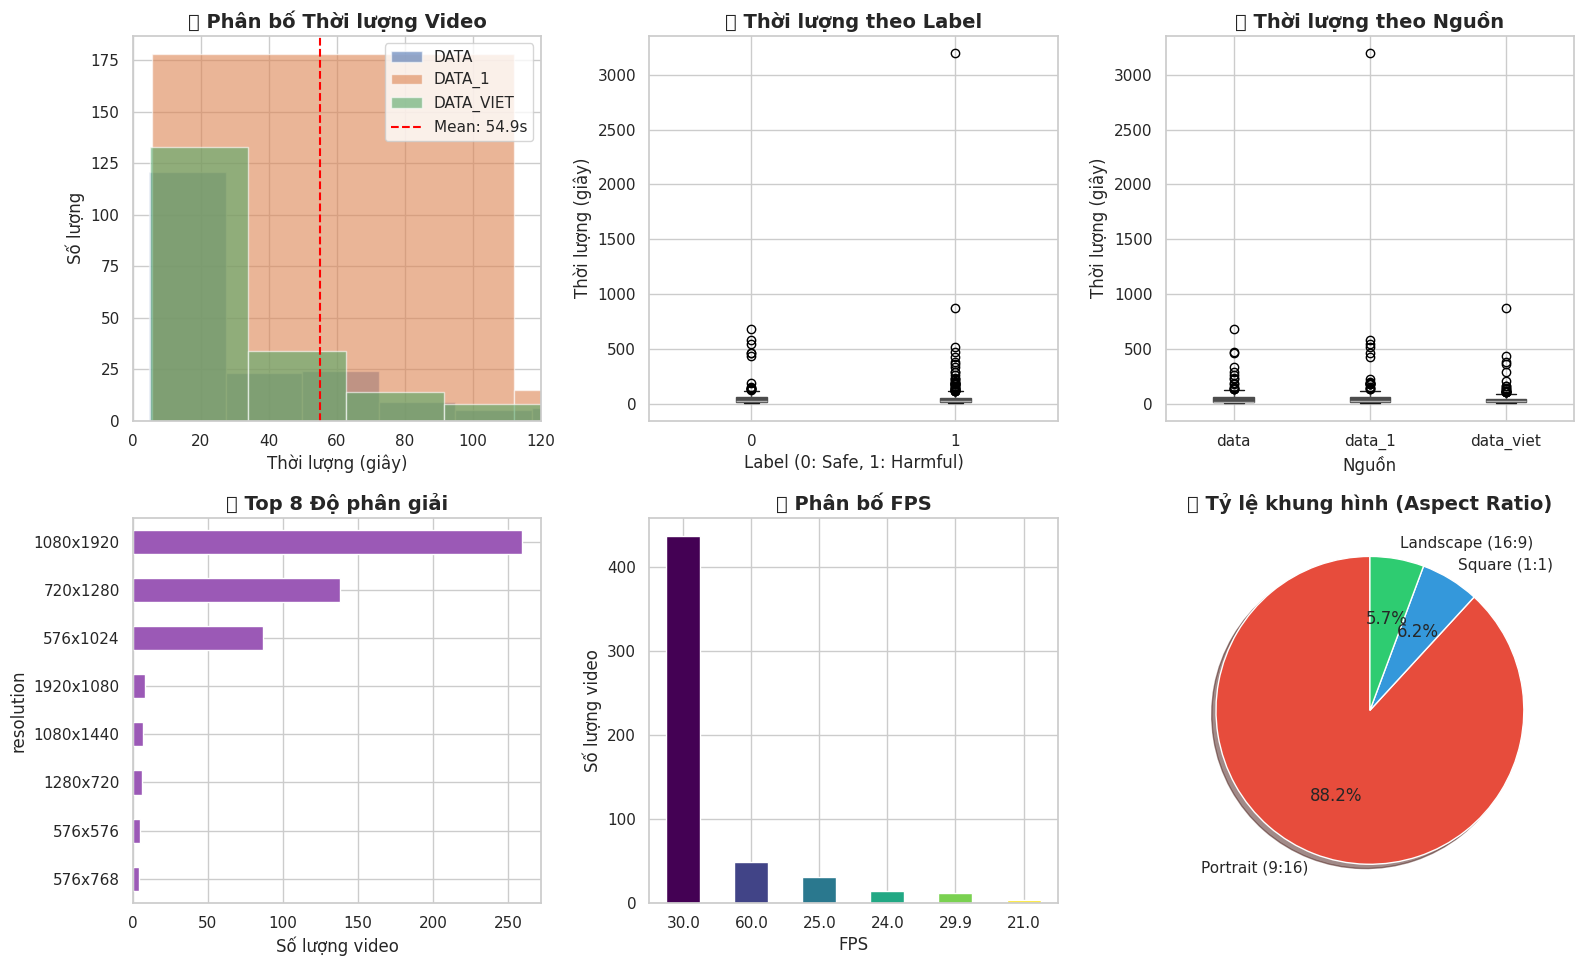

🎬 THỐNG KÊ METADATA VIDEO

⏱️ THỜI LƯỢNG (Duration):
   ├─ Trung bình: 54.9 giây
   ├─ Median:     21.6 giây
   ├─ Min:        4.7 giây
   ├─ Max:        3194.6 giây
   └─ P95:        159.9 giây

🖥️ TOP 5 ĐỘ PHÂN GIẢI:
   1. 1080x1920: 259 (43.2%)
   2. 720x1280: 138 (23.0%)
   3. 576x1024: 87 (14.5%)
   4. 1920x1080: 8 (1.3%)
   5. 1080x1440: 7 (1.2%)

🎞️ TOP 5 FPS:
   1. 30.0 FPS: 437 (72.8%)
   2. 60.0 FPS: 49 (8.2%)
   3. 25.0 FPS: 31 (5.2%)
   4. 24.0 FPS: 14 (2.3%)
   5. 29.9 FPS: 12 (2.0%)

📐 ASPECT RATIO:
   Portrait (9:16): 529 (88.2%)
   Square (1:1): 37 (6.2%)
   Landscape (16:9): 34 (5.7%)

----------------------------------------------------------------------
💡 GỢI Ý CHO VIDEO MODEL CONFIG:
   ├─ num_frames: 16-32 frames (video ~15-30s)
   ├─ image_size: 224x224 (chuẩn VideoMAE)
   └─ Chú ý: Phần lớn video là Portrait (9:16) - TikTok format


In [ ]:
# =============================================================================
# 📊 VISUALIZE VIDEO METADATA
# =============================================================================

if len(df_video) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    # Row 1: Duration Analysis
    # 1.1 Duration Distribution
    ax1 = axes[0, 0]
    for source in df_video["source"].unique():
        subset = df_video[df_video["source"] == source]["duration"]
        ax1.hist(subset, bins=30, alpha=0.6, label=source.upper(), edgecolor="white")
    ax1.axvline(
        df_video["duration"].mean(),
        color="red",
        linestyle="--",
        label=f'Mean: {df_video["duration"].mean():.1f}s',
    )
    ax1.set_title("⏱️ Phân bố Thời lượng Video", fontweight="bold")
    ax1.set_xlabel("Thời lượng (giây)")
    ax1.set_ylabel("Số lượng")
    ax1.set_xlim(0, 120)  # TikTok max 3 phút = 180s, zoom vào 120s
    ax1.legend()

    # 1.2 Duration by Label
    ax2 = axes[0, 1]
    df_video.boxplot(column="duration", by="label", ax=ax2, patch_artist=True)
    ax2.set_title("⏱️ Thời lượng theo Label", fontweight="bold")
    ax2.set_xlabel("Label (0: Safe, 1: Harmful)")
    ax2.set_ylabel("Thời lượng (giây)")
    plt.suptitle("")

    # 1.3 Duration by Source
    ax3 = axes[0, 2]
    df_video.boxplot(column="duration", by="source", ax=ax3, patch_artist=True)
    ax3.set_title("⏱️ Thời lượng theo Nguồn", fontweight="bold")
    ax3.set_xlabel("Nguồn")
    ax3.set_ylabel("Thời lượng (giây)")
    plt.suptitle("")

    # Row 2: Resolution & FPS
    # 2.1 Top Resolutions
    ax4 = axes[1, 0]
    res_counts = df_video["resolution"].value_counts().head(8)
    res_counts.plot(kind="barh", ax=ax4, color="#9b59b6", edgecolor="white")
    ax4.set_title("🖥️ Top 8 Độ phân giải", fontweight="bold")
    ax4.set_xlabel("Số lượng video")
    ax4.invert_yaxis()

    # 2.2 FPS Distribution
    ax5 = axes[1, 1]
    fps_counts = df_video["fps"].value_counts().head(6)
    colors = plt.cm.viridis(np.linspace(0, 1, len(fps_counts)))
    fps_counts.plot(kind="bar", ax=ax5, color=colors, edgecolor="white")
    ax5.set_title("🎞️ Phân bố FPS", fontweight="bold")
    ax5.set_xlabel("FPS")
    ax5.set_ylabel("Số lượng video")
    ax5.tick_params(axis="x", rotation=0)

    # 2.3 Aspect Ratio Analysis
    ax6 = axes[1, 2]
    df_video["aspect_ratio"] = df_video["width"] / df_video["height"]

    # Categorize aspect ratios
    def categorize_aspect(ratio):
        if ratio < 0.7:
            return "Portrait (9:16)"
        elif ratio > 1.3:
            return "Landscape (16:9)"
        else:
            return "Square (1:1)"

    df_video["aspect_type"] = df_video["aspect_ratio"].apply(categorize_aspect)
    aspect_counts = df_video["aspect_type"].value_counts()

    colors = ["#e74c3c", "#3498db", "#2ecc71"]
    ax6.pie(
        aspect_counts.values,
        labels=aspect_counts.index,
        colors=colors,
        autopct="%1.1f%%",
        startangle=90,
        shadow=True,
    )
    ax6.set_title("📐 Tỷ lệ khung hình (Aspect Ratio)", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Report thống kê
    print("=" * 70)
    print("🎬 THỐNG KÊ METADATA VIDEO")
    print("=" * 70)

    print("\n⏱️ THỜI LƯỢNG (Duration):")
    print(f"   ├─ Trung bình: {df_video['duration'].mean():.1f} giây")
    print(f"   ├─ Median:     {df_video['duration'].median():.1f} giây")
    print(f"   ├─ Min:        {df_video['duration'].min():.1f} giây")
    print(f"   ├─ Max:        {df_video['duration'].max():.1f} giây")
    print(f"   └─ P95:        {np.percentile(df_video['duration'], 95):.1f} giây")

    print("\n🖥️ TOP 5 ĐỘ PHÂN GIẢI:")
    for i, (res, count) in enumerate(
        df_video["resolution"].value_counts().head(5).items(), 1
    ):
        pct = 100 * count / len(df_video)
        print(f"   {i}. {res}: {count} ({pct:.1f}%)")

    print("\n🎞️ TOP 5 FPS:")
    for i, (fps, count) in enumerate(df_video["fps"].value_counts().head(5).items(), 1):
        pct = 100 * count / len(df_video)
        print(f"   {i}. {fps} FPS: {count} ({pct:.1f}%)")

    print("\n📐 ASPECT RATIO:")
    for aspect, count in aspect_counts.items():
        pct = 100 * count / len(df_video)
        print(f"   {aspect}: {count} ({pct:.1f}%)")

    print("\n" + "-" * 70)
    print("💡 GỢI Ý CHO VIDEO MODEL CONFIG:")
    print(f"   ├─ num_frames: 16-32 frames (video ~15-30s)")
    print(f"   ├─ image_size: 224x224 (chuẩn VideoMAE)")
    print(f"   └─ Chú ý: Phần lớn video là Portrait (9:16) - TikTok format")
    print("=" * 70)


## 2.3 Phân tích Hashtags từ Crawl Data

Phân tích các hashtags được crawl để hiểu chủ đề Harmful vs Not Harmful.

✅ Loaded data: 4,000 links
✅ Loaded data_1: 1,000 links
✅ Loaded data_viet: 146 links

📊 Tổng số links: 5,146


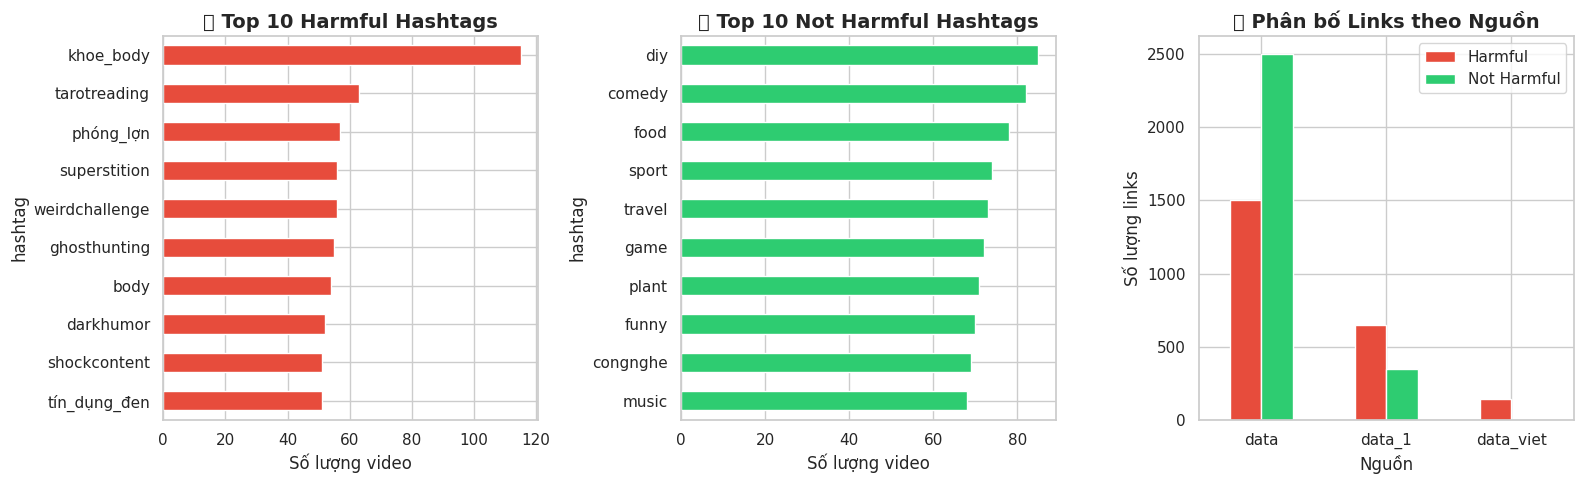

#️⃣ THỐNG KÊ HASHTAGS

🔴 TOP 10 HARMFUL HASHTAGS:
    1. #khoe_body: 115
    2. #tarotreading: 63
    3. #phóng_lợn: 57
    4. #superstition: 56
    5. #weirdchallenge: 56
    6. #ghosthunting: 55
    7. #body: 54
    8. #darkhumor: 52
    9. #shockcontent: 51
   10. #tín_dụng_đen: 51

🟢 TOP 10 SAFE HASHTAGS:
    1. #diy: 85
    2. #comedy: 82
    3. #food: 78
    4. #sport: 74
    5. #travel: 73
    6. #game: 72
    7. #plant: 71
    8. #funny: 70
    9. #congnghe: 69
   10. #music: 68


In [ ]:
# =============================================================================
# #️⃣ PHÂN TÍCH HASHTAGS TỪ CRAWL DATA
# =============================================================================


def load_crawl_data():
    """Load và gộp crawl data từ tất cả nguồn"""
    crawl_dfs = []

    for source_name, paths in VIDEO_SOURCES.items():
        crawl_path = paths.get("crawl_csv")
        if crawl_path and os.path.exists(crawl_path):
            try:
                df = pd.read_csv(crawl_path)
                df["source"] = source_name
                crawl_dfs.append(df)
                print(f"✅ Loaded {source_name}: {len(df):,} links")
            except Exception as e:
                print(f"❌ Error loading {source_name}: {e}")

    if crawl_dfs:
        return pd.concat(crawl_dfs, ignore_index=True)
    return None


df_crawl = load_crawl_data()

if df_crawl is not None and "hashtag" in df_crawl.columns:
    print(f"\n📊 Tổng số links: {len(df_crawl):,}")

    # Thống kê hashtags
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # 1. Top Harmful hashtags
    ax1 = axes[0]
    harmful_hashtags = (
        df_crawl[df_crawl["label"] == "harmful"]["hashtag"].value_counts().head(10)
    )
    harmful_hashtags.plot(kind="barh", ax=ax1, color="#e74c3c", edgecolor="white")
    ax1.set_title("🔴 Top 10 Harmful Hashtags", fontweight="bold")
    ax1.set_xlabel("Số lượng video")
    ax1.invert_yaxis()

    # 2. Top Not Harmful hashtags
    ax2 = axes[1]
    safe_hashtags = (
        df_crawl[df_crawl["label"] == "not_harmful"]["hashtag"].value_counts().head(10)
    )
    safe_hashtags.plot(kind="barh", ax=ax2, color="#2ecc71", edgecolor="white")
    ax2.set_title("🟢 Top 10 Not Harmful Hashtags", fontweight="bold")
    ax2.set_xlabel("Số lượng video")
    ax2.invert_yaxis()

    # 3. Hashtag distribution by source
    ax3 = axes[2]
    source_label_counts = (
        df_crawl.groupby(["source", "label"]).size().unstack(fill_value=0)
    )
    source_label_counts.plot(
        kind="bar", ax=ax3, color=["#e74c3c", "#2ecc71"], edgecolor="white"
    )
    ax3.set_title("📊 Phân bố Links theo Nguồn", fontweight="bold")
    ax3.set_xlabel("Nguồn")
    ax3.set_ylabel("Số lượng links")
    ax3.legend(["Harmful", "Not Harmful"])
    ax3.tick_params(axis="x", rotation=0)

    plt.tight_layout()
    plt.show()

    # Report
    print("=" * 60)
    print("#️⃣ THỐNG KÊ HASHTAGS")
    print("=" * 60)

    print("\n🔴 TOP 10 HARMFUL HASHTAGS:")
    for i, (tag, count) in enumerate(harmful_hashtags.items(), 1):
        print(f"   {i:2}. #{tag}: {count}")

    print("\n🟢 TOP 10 SAFE HASHTAGS:")
    for i, (tag, count) in enumerate(safe_hashtags.items(), 1):
        print(f"   {i:2}. #{tag}: {count}")

    print("=" * 60)
else:
    print("⚠️ Không tìm thấy crawl data hoặc thiếu cột 'hashtag'")


# 📋 PHẦN 3: TỔNG HỢP VÀ KHUYẾN NGHỊ

## 3.1 Summary Dashboard

In [ ]:
# =============================================================================
# 📋 SUMMARY DASHBOARD - TỔNG HỢP EDA
# =============================================================================

print("=" * 70)
print("🛡️ TIKTOK SAFETY PLATFORM - EDA SUMMARY")
print("=" * 70)

# TEXT DATA Summary
if "df_text" in dir():
    print("\n📝 TEXT DATA:")
    print(f"   ├─ Tổng số mẫu: {len(df_text):,}")
    print(
        f"   ├─ Not Harmful (0): {(df_text['label']==0).sum():,} ({100*(df_text['label']==0).mean():.1f}%)"
    )
    print(
        f"   ├─ Harmful (1): {(df_text['label']==1).sum():,} ({100*(df_text['label']==1).mean():.1f}%)"
    )
    print(f"   ├─ Avg word count: {df_text['word_count'].mean():.0f} từ")
    print(f"   └─ Avg comments/video: {df_text['sep_count'].mean():.1f} comments")

# VIDEO DATA Summary
print("\n🎬 VIDEO DATA:")
for source_name, stats in video_stats.items():
    total = stats["total"]
    if total > 0:
        harm_pct = 100 * stats["harmful"] / total
        print(
            f"   📁 {source_name.upper()}: {total:,} videos ({harm_pct:.1f}% harmful)"
        )

print(f"\n   📊 TOTAL: {sum(s['total'] for s in video_stats.values()):,} videos")

if "df_video" in dir() and len(df_video) > 0:
    print(f"\n   🎥 Video Metadata (sampled):")
    print(f"      ├─ Avg duration: {df_video['duration'].mean():.1f}s")
    print(
        f"      ├─ Top resolution: {df_video['resolution'].mode().iloc[0] if len(df_video['resolution'].mode()) > 0 else 'N/A'}"
    )
    print(
        f"      └─ Top FPS: {df_video['fps'].mode().iloc[0] if len(df_video['fps'].mode()) > 0 else 'N/A'}"
    )

print("\n" + "=" * 70)
print("💡 KHUYẾN NGHỊ CHO MODEL TRAINING")
print("=" * 70)

print(
    """
📝 TEXT MODEL (CafeBERT):
   ├─ max_seq_length: 512 tokens (bao phủ 95% data)
   ├─ Sử dụng class_weights để xử lý imbalance
   └─ Pretrained: uitnlp/CafeBERT (Vietnamese-English multilingual)

🎬 VIDEO MODEL (VideoMAE):
   ├─ num_frames: 16-32 frames
   ├─ image_size: 224x224
   ├─ Chú ý: TikTok videos chủ yếu Portrait (9:16)
   └─ Pretrained: MCG-NJU/videomae-base

🔗 FUSION MODEL:
   ├─ Text embedding: 1024-dim (CafeBERT)
   ├─ Video embedding: 768-dim (VideoMAE)
   └─ Fusion strategy: Concatenate + MLP classifier
"""
)

print("=" * 70)
print("✅ EDA HOÀN TẤT!")
print("=" * 70)


🛡️ TIKTOK SAFETY PLATFORM - EDA SUMMARY

📝 TEXT DATA:
   ├─ Tổng số mẫu: 2,430
   ├─ Not Harmful (0): 1,912 (78.7%)
   ├─ Harmful (1): 518 (21.3%)
   ├─ Avg word count: 535 từ
   └─ Avg comments/video: 61.9 comments

🎬 VIDEO DATA:
   📁 DATA: 959 videos (45.4% harmful)
   📁 DATA_1: 838 videos (64.4% harmful)
   📁 DATA_VIET: 818 videos (66.0% harmful)

   📊 TOTAL: 2,615 videos

   🎥 Video Metadata (sampled):
      ├─ Avg duration: 54.9s
      ├─ Top resolution: 1080x1920
      └─ Top FPS: 30.0

💡 KHUYẾN NGHỊ CHO MODEL TRAINING

📝 TEXT MODEL (CafeBERT):
   ├─ max_seq_length: 512 tokens (bao phủ 95% data)
   ├─ Sử dụng class_weights để xử lý imbalance
   └─ Pretrained: uitnlp/CafeBERT (Vietnamese-English multilingual)

🎬 VIDEO MODEL (VideoMAE):
   ├─ num_frames: 16-32 frames
   ├─ image_size: 224x224
   ├─ Chú ý: TikTok videos chủ yếu Portrait (9:16)
   └─ Pretrained: MCG-NJU/videomae-base

🔗 FUSION MODEL:
   ├─ Text embedding: 1024-dim (CafeBERT)
   ├─ Video embedding: 768-dim (VideoMAE)
